## Data preparation

In [1]:
import pandas as pd
import random
import math
import numpy as np
from geopy.geocoders import Nominatim
from geopy.distance import distance
import matplotlib.pyplot as plt
from IPython.display import Image
import imageio.v2 as imageio

# list of 30 most populated cities in Russia
cities = ["Moscow", "Saint Petersburg", "Novosibirsk", "Yekaterinburg", "Nizhny Novgorod", "Kazan", "Chelyabinsk", 
          "Omsk", "Samara", "Rostov-on-Don", "Ufa", "Krasnoyarsk", "Perm", "Voronezh", "Volgograd", "Krasnodar", 
          "Saratov", "Tyumen", "Tolyatti", "Izhevsk", "Barnaul", "Ulyanovsk", "Vladivostok", "Yaroslavl", 
          "Khabarovsk", "Makhachkala", "Orenburg", "Kemerovo", "Novokuznetsk", "Ryazan"]

# downloading the coordinates of these cities using geopy
geolocator = Nominatim(user_agent="my_app")

latitudes = []
longitudes = []

for city in cities:
    location = geolocator.geocode(city + ", Russia")
    latitudes.append(location.latitude)
    longitudes.append(location.longitude)

cities_df = pd.DataFrame({'City': cities, 'Latitude': latitudes, 'Longitude': longitudes})

print(cities_df)


                City   Latitude   Longitude
0             Moscow  55.750446   37.617494
1   Saint Petersburg  59.938732   30.316229
2        Novosibirsk  55.028831   82.922689
3      Yekaterinburg  56.839104   60.608250
4    Nizhny Novgorod  56.326482   44.005139
5              Kazan  55.782355   49.124227
6        Chelyabinsk  55.159841   61.402555
7               Omsk  54.991375   73.371529
8             Samara  53.198627   50.113987
9      Rostov-on-Don  47.221655   39.709606
10               Ufa  54.726141   55.947499
11       Krasnoyarsk  56.009097   92.872515
12              Perm  58.014965   56.246723
13          Voronezh  51.660598   39.200586
14         Volgograd  48.708191   44.515335
15         Krasnodar  45.768401   39.026104
16           Saratov  51.530018   46.034683
17            Tyumen  57.153534   65.542274
18          Tolyatti  53.514988   49.407332
19           Izhevsk  56.866557   53.209417
20           Barnaul  53.347549   83.778845
21         Ulyanovsk  54.310759 

In [2]:
# calculating the distances between each 2 of these cities
n = len(cities)
dist_matrix = np.zeros((n, n))

for i in range(n):
    for j in range(i+1, n):
        loc1 = (cities_df['Latitude'][i], cities_df['Longitude'][i])
        loc2 = (cities_df['Latitude'][j], cities_df['Longitude'][j])
        dist_matrix[i][j] = distance(loc1, loc2).km
        dist_matrix[j][i] = dist_matrix[i][j]

dist_df = pd.DataFrame(dist_matrix, columns=cities, index=cities)

print(dist_df)

                       Moscow  Saint Petersburg  Novosibirsk  Yekaterinburg  \
Moscow               0.000000        636.169514  2820.694034    1421.897198   
Saint Petersburg   636.169514          0.000000  3115.600421    1788.462413   
Novosibirsk       2820.694034       3115.600421     0.000000    1402.680942   
Yekaterinburg     1421.897198       1788.462413  1402.680942       0.000000   
Nizhny Novgorod    403.127101        898.969222  2419.827705    1019.352356   
Kazan              721.439590       1203.380387  2121.367658     719.544016   
Chelyabinsk       1498.859249       1915.778772  1368.554574     193.425377   
Omsk              2243.230614       2592.659159   610.603522     822.817252   
Samara             857.034063       1421.530106  2135.306454     782.880913   
Rostov-on-Don      959.834564       1542.518990  3092.294234    1777.505124   
Ufa               1168.153047       1636.580909  1721.068193     375.170153   
Krasnoyarsk       3364.537371       3587.317269   63

## Simulated Annealing algorithm implementation

In [3]:
def neighbours(path):
    # for a given path, returns a list of "neighbours"
    # a path is a sequence of cities
    # a "neighbour" of the path is an alteration of this path with any 2 successive cities swapped
    neighbours_list = []
    for i in range(len(path)):
        new_path = path.copy()
        new_path[i], new_path[i - 1] = new_path[i - 1], new_path[i]
        neighbours_list.append(new_path)
    return neighbours_list

def neighbour(path):
    # for a given path, randomly returns one of its neighbours
    return random.choice(neighbours(path))
    

In [4]:
def energy(path):
    # for a given path, calculates its total distance 
    # = sum of distances between each of 2 successive cities in it
    res = 0
    prev = 0
    for v in path:
        res += dist_matrix[prev][v]
        prev = v
    res += dist_matrix[prev][0]
    return res

In [5]:
def acceptance_ratio(path, new_path, T):
    return math.exp((energy(path) - energy(new_path))/T)

In [6]:
def SA(cooldown_factor, initial_T_coefficient=100):
    
    # setting initial values of the algorithm parameters
    path = list(range(1, n))
    random.shuffle(path) # initial random path
    x = [path] # stores states occuring during SA
    T = energy(path) * initial_T_coefficient # temperature

    while T > 1:
        path = x[-1]
        new_path = neighbour(path)
        u = random.random() # ~u(0,1)
        if u <= acceptance_ratio(path, new_path, T):
            x.append(new_path)
        else:
            x.append(path)
        T *= cooldown_factor
    return x

## Visualizations

In [7]:
def plot_optimization_process(x):
    energies = list(map(energy, x))
    plt.plot(energies)
    plt.xlabel('Iteration')
    plt.ylabel('Energy')
    plt.title('Simulated Annealing: Energy vs. Iteration')
    plt.show()

In [12]:
def plot_path(path):
    # for a given path (sequence of cities), creates a plot
    # that visualizes cities locations using points 
    # and links consecutive cities using lines
    path = [0] + path + [0]
    plt.scatter(cities_df['Longitude'], cities_df['Latitude'], marker='o', color='blue')

    for i, city in enumerate(cities_df['City']):
        plt.annotate(city, (cities_df.iloc[i]['Longitude'], cities_df.iloc[i]['Latitude']))

    path_x = [cities_df.loc[idx, 'Longitude'] for idx in path]
    path_y = [cities_df.loc[idx, 'Latitude'] for idx in path]
    path_labels = [cities_df.loc[idx, 'City'] for idx in path]
    plt.plot(path_x, path_y, color='red')

    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.plot()

In [18]:
def create_gif_visualizing_optimization_process(x, number_of_plots, cooling):
    # creates a gif that visualizes 
    # each len(x) // number_of_plots step of optimization process 
    # using plot_path function
    step = len(x) // number_of_plots
    for i in range(0, len(x), step):
        plot_path(x[i])
        plt.title(f'generation {i}. energy {energy(x[i])}')
        plt.savefig(str(cooling) + str(i) + '.png')
        plt.clf()

    with imageio.get_writer('mygif.gif', mode='I') as writer:
        for i in range(0, len(x), step):
            image = imageio.imread(str(cooling) + str(i) + '.png')
            writer.append_data(image)

    Image(open('mygif.gif','rb').read())

##Experiments

###Fast cooling

In [9]:
x = SA(cooldown_factor=0.95)

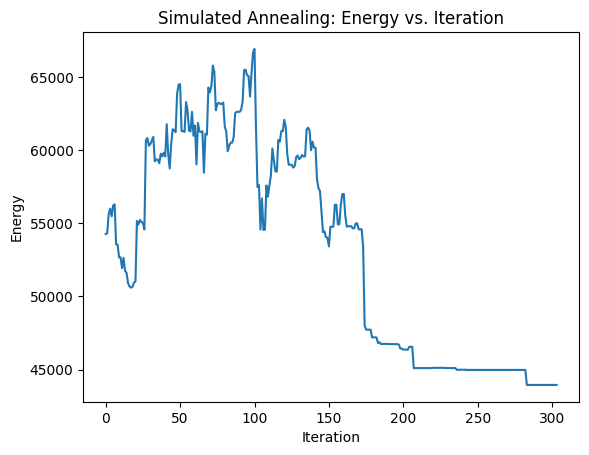

In [10]:
plot_optimization_process(x)

In [13]:
create_gif_visualizing_optimization_process(x, number_of_plots=20, cooling="fast")

<Figure size 640x480 with 0 Axes>

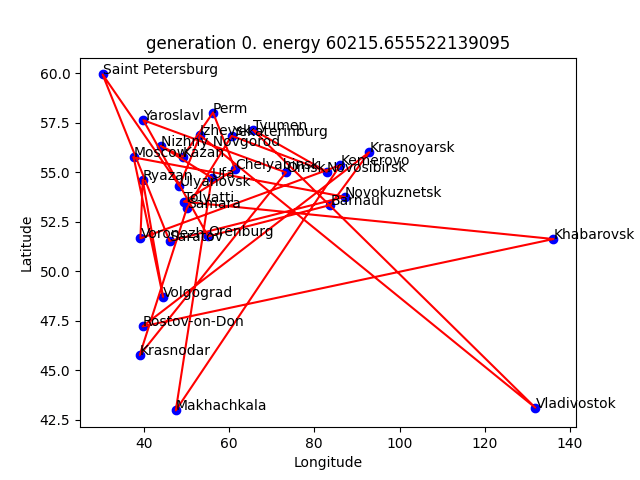

In [42]:
Image(open('mygif.gif','rb').read())

### Slow cooling

In [14]:
x = SA(cooldown_factor=0.9999)

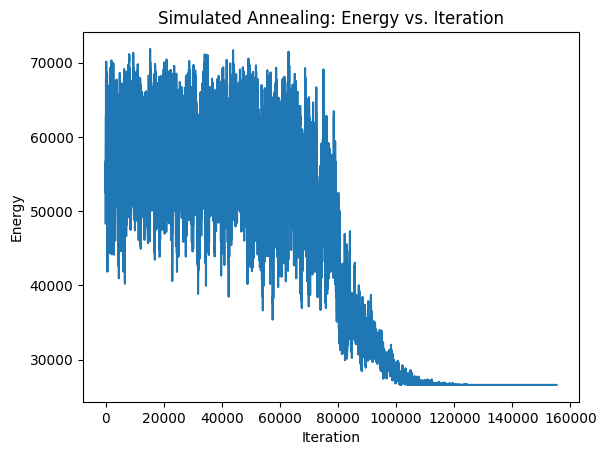

In [15]:
plot_optimization_process(x)

In [19]:
create_gif_visualizing_optimization_process(x, number_of_plots=50, cooling="slow")

<Figure size 640x480 with 0 Axes>

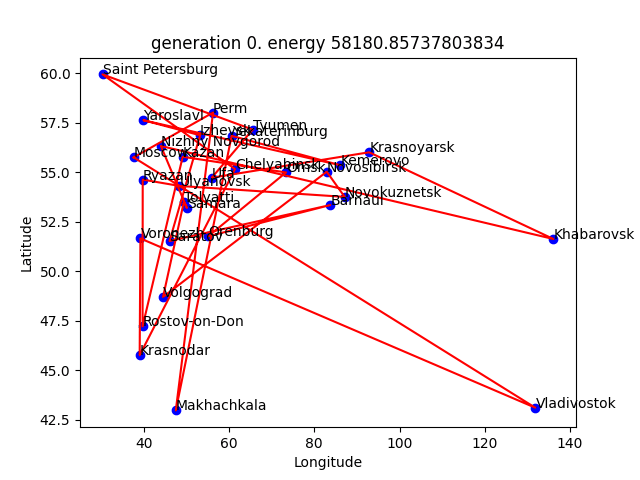

In [46]:
Image(open('mygif.gif','rb').read())

### Medium-rare cooling

In [20]:
x = SA(cooldown_factor=0.997)

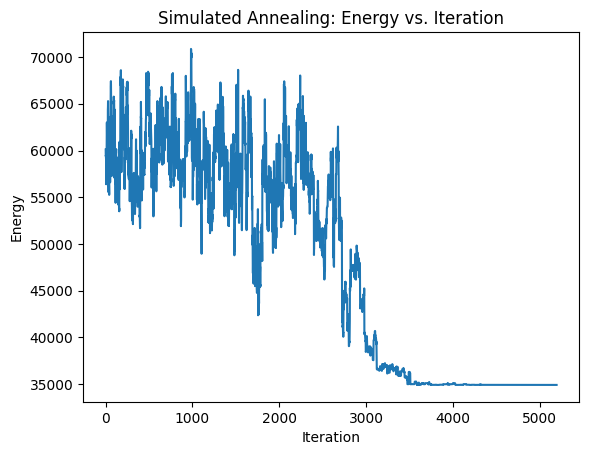

In [21]:
plot_optimization_process(x)

In [22]:
create_gif_visualizing_optimization_process(x, number_of_plots=40, cooling="medium")

<Figure size 640x480 with 0 Axes>

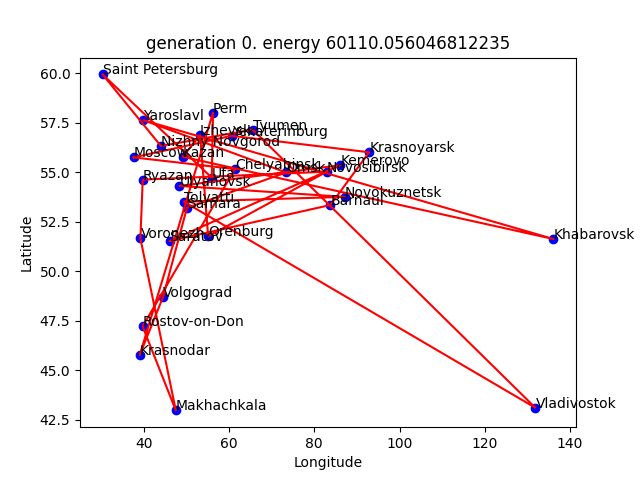

In [23]:
Image(open('mygif.gif','rb').read())